# NBA Game Prediction: Logistic Regression Matchups
Written by Nicholas Cannon

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay, precision_recall_curve,
    PrecisionRecallDisplay
)
from pandasql import sqldf

%matplotlib inline

DATA_DIR = os.path.join('..', 'data', 'processed', 'games')
STATE = 42

In [26]:
def run_metrics(y_pred, y_true):    
    print('F1 =', f1_score(y_true, y_pred, average='weighted'))
    print('Accuracy =', accuracy_score(y_true, y_pred))
    print('n games =', len(y_pred))
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    ConfusionMatrixDisplay(
        confusion_matrix(y_true, y_pred),
        display_labels=['Lose', 'Win']
    ).plot(cmap=plt.cm.Blues, ax=ax1)
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr)).plot(ax=ax2)
    
    prec, recall, _ = precision_recall_curve(y_pred, y_true)
    PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax3)
    
    plt.show()

def load_season(season):
    """Load season data and apply basic preprocessing"""
    df = pd.read_csv(os.path.join(DATA_DIR, season))
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.sort_values('DATE', inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df


def get_matchup_games(df, team1, team2):
    """Return all games played between both teams"""
    df1 = df[(df['H_ID'] == team1) ^ (df['A_ID'] == team1)]
    df2 = df[(df['H_ID'] == team2) ^ (df['A_ID'] == team2)]
    games = pd.merge(df1, df2, on='GAME_ID')['GAME_ID']

    return df[df['GAME_ID'].isin(games)]

In [27]:
# df = pd.concat([load_season('2014-full.csv'), load_season('2015-full.csv')], ignore_index=True)

df = load_season('2018-full.csv')
df['HOME_WIN'].value_counts()

1    729
0    501
Name: HOME_WIN, dtype: int64

# Baseline Models

## Always pick home team

F1 = 0.44110857953908783
Accuracy = 0.5926829268292683
n games = 1230


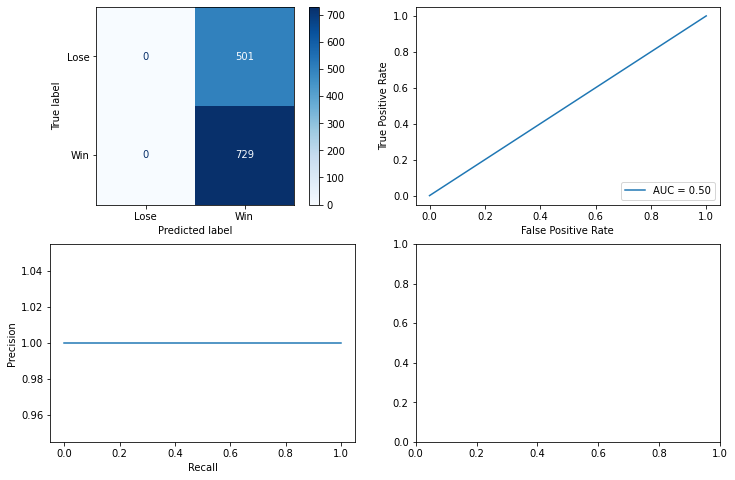

In [28]:
y_home = np.ones((df.shape[0],))
run_metrics(y_home, df['HOME_WIN'])

## Always pick the team who won last matchup
Pick the team who won the last matchup, if no previous matchup exists pick the home team.

In [29]:
# keyed by sorted team ids
last_games = {}
won_last = []

for _, data in df.iterrows():
    matchup_ids = tuple(sorted([data['H_ID'], data['A_ID']]))

    history = last_games.get(matchup_ids, None)
    if history is None:
        # pick home team when no history available
        won_last.append(data['H_ID'])
    else:
        won_last.append(history)
    
    # add this game as the new last game
    last_games[matchup_ids] = data['H_ID'] if data['HOME_WIN'] else data['A_ID']

df['WON_LAST'] = won_last
df.dropna(inplace=True)
df['H_WON_LAST'] = df.apply(lambda row: 1 if row['H_ID'] == row['WON_LAST'] else 0, axis=1)

# Feature validation
# matchup = get_matchup_games(df, 1610612739, 1610612766)
# matchup[['A_ID', 'H_ID', 'HOME_WIN', 'WON_LAST', 'H_WON_LAST']]

F1 = 0.5387556943017995
Accuracy = 0.5447154471544715
n games = 1230


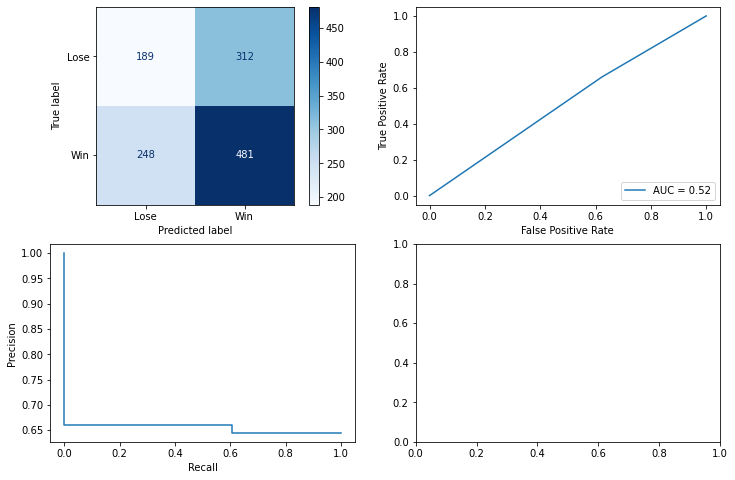

In [31]:
y_last_win = df['H_WON_LAST']
run_metrics(y_last_win, df['HOME_WIN'])

## Always pick the series leader
Pick Home team if the series is tied

In [32]:
# keyed by sorted team ids
matchup_history = defaultdict(list)
series_leader = []

for _, data in df.iterrows():
    matchup_ids = tuple(sorted([data['H_ID'], data['A_ID']]))

    history = matchup_history.get(matchup_ids, None)
    if history is None:
        # pick home team when no history available
        series_leader.append(data['H_ID'])
    else:
        if history.count(data['H_ID']) >= history.count(data['A_ID']):
            # home team is series leader
            series_leader.append(data['H_ID'])
        else:
            # away team is series leader
            series_leader.append(data['A_ID'])
    
    # add the result of this game to the history
    matchup_history[matchup_ids].append(data['H_ID'] if data['HOME_WIN'] else data['A_ID'])
    
df['SERIES_LEADER'] = series_leader
df['H_LEADER'] = df.apply(lambda row: 1 if row['H_ID'] == row['SERIES_LEADER'] else 0, axis=1)

# Feature validation
# matchup = get_matchup_games(df, 1610612739, 1610612766)
# matchup[['A_ID', 'H_ID', 'HOME_WIN', 'SERIES_LEADER', 'H_LEADER']]

F1 = 0.5605965466967578
Accuracy = 0.5739837398373984
n games = 1230


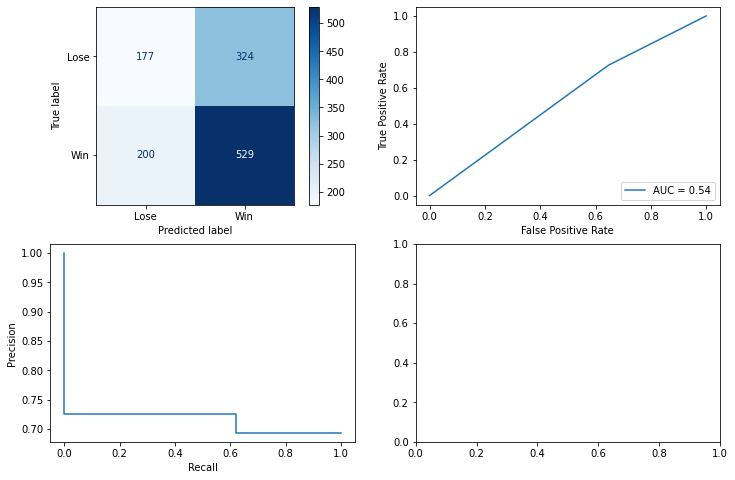

In [33]:
y_series_leader = df['H_LEADER']
run_metrics(y_series_leader, df['HOME_WIN'])

# Linear Regression Model

In [34]:
# encode team ids
team_enc = OneHotEncoder(sparse=False)
teams = team_enc.fit_transform(df[['H_ID', 'A_ID']])

F1 = 0.6515440002647064
Accuracy = 0.6495934959349593
n games = 1230


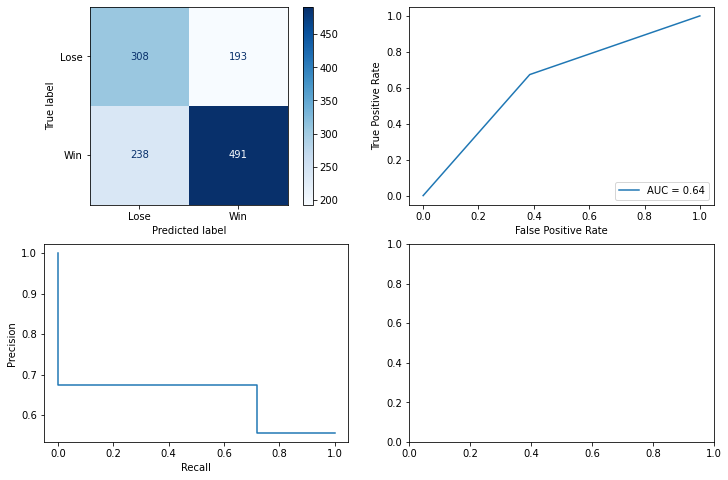

In [35]:
clf = LogisticRegression(solver='liblinear', class_weight='balanced',
                         random_state=STATE, n_jobs=-1)
X = np.hstack([
    df['H_WON_LAST'].values.reshape(-1, 1),
    df['H_LEADER'].values.reshape(-1, 1),
    teams,
])

y_pred = cross_val_predict(clf, X, df['HOME_WIN'].values, cv=5, n_jobs=-1)
run_metrics(y_pred, df['HOME_WIN'])